In [1]:
import mysql.connector

In [43]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [46]:
vec = pickle.load(open("df1.pkl", 'rb'))
loaded_model = pickle.load(open("tip.sav", 'rb'))

In [3]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="root"
)

In [4]:
mycursor = mydb.cursor()

mycursor.execute("CREATE DATABASE xenathon")

In [5]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  password="root",
  database="xenathon"
)

mycursor = mydb.cursor()

In [19]:
mycursor.execute("DROP TABLE customers")

In [20]:
mycursor.execute("CREATE TABLE customers (prodid VARCHAR(255),prodname VARCHAR(1000) ,mailid VARCHAR(255),userid INT,review VARCHAR(10000))")

In [21]:
mycursor = mydb.cursor()

mycursor.execute("SHOW TABLES")

for x in mycursor:
    print(x)

('customers',)


In [14]:
import pandas as pd

In [15]:
df=pd.read_csv('sql_dt.csv')

In [23]:
sql = "INSERT INTO customers (prodid, prodname,mailid,userid,review) VALUES (%s, %s, %s, %d, %s)"

In [62]:
df.tail()

,StockCode,Description,mailid,CustomerID,reviews
406824,22613,PACK OF 20 SPACEBOY NAPKINS,rohan10.rohan10@gmail.com,12680,I thought the book was not very good. And that...
406825,22899,CHILDREN'S APRON DOLLY GIRL,rohan10.rohan10@gmail.com,12680,A good overview of technique possibilities
406826,23254,CHILDRENS CUTLERY DOLLY GIRL,rohan10.rohan10@gmail.com,12680,I enjoyed this book very much. You will too. B...
406827,23255,CHILDRENS CUTLERY CIRCUS PARADE,rohan10.rohan10@gmail.com,12680,white lion's lady
406828,22138,BAKING SET 9 PIECE RETROSPOT,rohan10.rohan10@gmail.com,12680,Whats to say? I loved this show. It was ver go...


In [34]:
df.dropna(inplace=True)

In [35]:
for ind in df.index:
    sql = "INSERT INTO customers (prodid, prodname,mailid,userid,review) VALUES (%s, %s, %s, %s, %s)"
    val=(df['StockCode'][ind], df['Description'][ind],df['mailid'][ind], int(df['CustomerID'][ind]),df['reviews'][ind])
    mycursor.execute(sql, val)
mydb.commit()

In [102]:
mycursor.execute("SELECT userid,review,mailid,prodname FROM customers WHERE prodid='71053'")

myresult = mycursor.fetchall()

l=[]
pos=[]
neg=[]
for x in myresult:
    rv=[x[1]]
    rv= vec.transform(rv)
    predct=loaded_model.predict(rv)
    l.append(predct[0])
    if(predct[0] == 0):
        neg.append(x[2])
    else:
        pos.append(x[2])

sz=len(l)
positive_percent=((sz-len(neg))/sz)*100
print(positive_percent)

54.71349353049908


In [101]:
(neg)

['rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.rohan10@gmail.com',
 'rohan10.

In [93]:
print(x[1])

This game was one that i was expecting to be good.Seeing all the previews at websites made it look awsome.But i realized quik when i bought it it was completely different.Some of the visuals are very well done,but wheres the fun?It seemed like they forgot to put it in.This is a game that is all graphics,no game.


In [94]:
type(myresult)

list

In [95]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

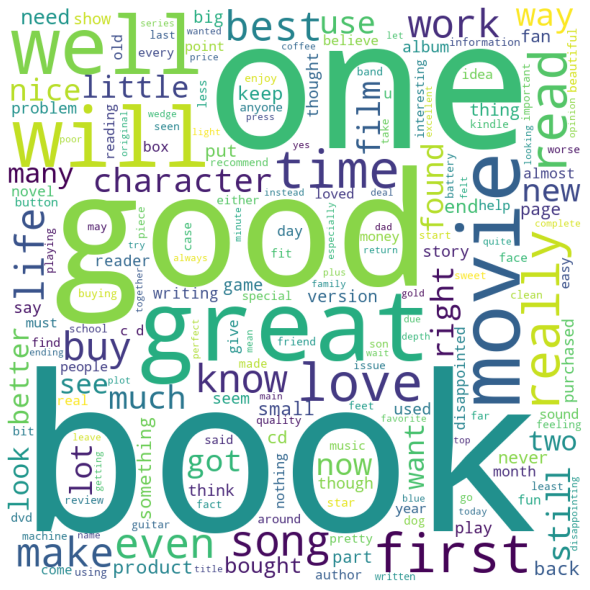

In [96]:
comment_words = ''
stopwords = set(STOPWORDS)
for val in myresult:
    val = str(val[1])
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [76]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [77]:
products = pd.read_csv("products.csv")
purchase = pd.read_csv("Purchase_His.csv")

In [78]:
final_dataset = purchase.pivot(index='StockCode',columns='CustomerID',values='Purchase')
final_dataset.fillna(0,inplace=True)
no_user_purchased = purchase.groupby('StockCode')['Purchase'].agg('count')
no_products_purchased = purchase.groupby('CustomerID')['Purchase'].agg('count')
final_dataset = final_dataset.loc[no_user_purchased[no_user_purchased > 10].index,:]
final_dataset=final_dataset.loc[:,no_products_purchased[no_products_purchased > 50].index]
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [85]:
def get_product_recommendation(product_name):
    n_products_to_reccomend = 10
    product_list = products[products['Description'].str.contains(product_name)]  
    if len(product_list):        
        product_idx= product_list.iloc[0]['StockCode']
        product_idx = final_dataset[final_dataset['StockCode'] == product_idx].index[0]
        distances , indices = knn.kneighbors(csr_data[product_idx],n_neighbors=n_products_to_reccomend+1)    
        rec_product_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
        recommend_frame = []
        for val in rec_product_indices:
            product_idx = final_dataset.iloc[val[0]]['StockCode']
            idx = products[products['StockCode'] == product_idx].index
            recommend_frame.append({'Description':products.iloc[idx]['Description'].values[0],'StockCode':products.iloc[idx]['StockCode'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_products_to_reccomend+1))
        return df
    else:
        return "Nothing To Recommend"

In [89]:
#mycursor.execute("SELECT userid,review,mailid,prodname FROM customers WHERE prodid='71053'")

#myresult = mycursor.fetchall()
data=myresult[1][3]
print(data)
get_product_recommendation(data)

WHITE METAL LANTERN


,Description,StockCode,Distance
1,LOVE GARLAND PAINTED ZINC,22341,0.779361
2,FRENCH CARRIAGE LANTERN,23099,0.768966
3,RED HANGING HEART T-LIGHT HOLDER,21733,0.762268
4,TRIANGULAR POUFFE VINTAGE,21628,0.761167
5,HANGING METAL HEART LANTERN,22464,0.759879
6,HANGING METAL STAR LANTERN,22465,0.754898
7,REGENCY CAKESTAND 3 TIER,22423,0.745674
8,SQUARE FLOOR CUSHION VINTAGE RED,21629,0.735961
9,WHITE HANGING HEART T-LIGHT HOLDER,85123A,0.724818
10,LANTERN CREAM GAZEBO,22784,0.678543
